# La paradoja de Parrondo

Este proyecto estudia dos fenómenos clásicos de la teoría de probabilidad: la ruina del jugador y la paradoja de Parrondo. 
A través de formulación teórica y simulaciones Monte Carlo, se analiza cómo funcionan estos modelos y por qué pueden producir 
comportamientos contraintuitivos

## Índice

- Introducción y objetivos

- Preliminares teóricos

- Cadenas de Markov y análisis de los juegos A y B independientes

- Paradoja de Parrondo

- Ruina del jugador

- Relación entre Parrondo y la ruina del jugador

- Conclusiones

- Referencias

# Introducción y objetivos

- Entender la teoría básica detrás de los simulaciones_juego tipo Parrondo, la ruina del jugador y las cadenas de Markov asociadas.

- Implementar simulaciones Monte Carlo para observar empíricamente los comportamientos descritos.

- Relacionar ambos modelos, mostrando cómo las dinámicas de avance/retroceso del capital pueden cambiar radicalmente al introducir reglas dependientes del estado.

## Preliminares teóricos

### Paseo aleatorio en 1D (Camino del borracho)

El paseo aleatorio unidimensional es un proceso en el que una variable —en este caso, el capital del jugador— cambia en pasos de +1 o −1 con ciertas probabilidades fijas.  
En cada jugada, el capital evoluciona según:


$$
X_{n+1} =
\begin{cases}
X_n + 1 & \text{con probabilidad } p, \\
X_n - 1 & \text{con probabilidad } q = 1 - p.
\end{cases}
$$


Este proceso genera trayectorias que pueden subir o bajar de forma aleatoria y que, a largo plazo, pueden presentar tendencias dependiendo de si $p > 1/2$, $p = 1/2$ o $p < 1/2$.

---

### Cadenas de Markov y estados absorbentes

Tanto este paseo aleatorio como los juegos de Parrondo pueden verse como cadenas de Markov.

Una cadena de Markov es un proceso estocástico con la propiedad de memoria corta:

El futuro del proceso depende solo del estado actual, no de la secuencia completa de estados anteriores.

En el contexto de juegos de azar, aparecen estados absorbentes, que son estados de los que no se puede salir una vez alcanzados.

---

### Notación utilizada

Para el resto del cuaderno manejaremos:

- Capital del jugador en la jugada (perteneciente a los naturales) $n$:  
  $
  X_n
  $

- Probabilidad de ganar una jugada:  
  $
  p
  $

- Probabilidad de perder una jugada:  
  $
  q = 1 - p
  $

- Estados especiales:
  - 0 → jugador arruinado  
  - N → jugador alcanza el objetivo o límite superior  

Desde cualquiera de estos dos estados no se sigue jugando; son estados absorbentes de la cadena.

---



## Paradoja de Parrondo

La paradoja de Parrondo describe un fenómeno en el que dos juegos que tienen esperanza de perder capital por si solos, al combinarse de cierta forma, se vuelven ganadores en promedio.
Cada juego individual hace que el dinero que tiene el jugador tienda a disminuir, pero cuando se alternan de manera ordenada o se mezclan aleatoriamente, el resultado total puede ser favorable para el jugador. Es un ejemplo de cómo la estructura de dependencia de estado entre juegos puede generar efectos contrarios a la intuición.

### Juego A

Para este juego tenemos una moneda ligeramente trucada, con probabilidad de ganar $p = 0.495$ y $q = 1 - p = 0.505$.
Cada vez que ganamos nuestro dinero aumenta (+1) y cada vez que perdemos nuestro dinero disminuye (-1).
Con esta información podemos estudiar el valor esperado de una tirada:

$$
\mathbb{E}[\Delta X] \;=\; p \cdot (+1) \;+\; q\cdot(-1) \;=\; 2p - 1
$$

Y en nuestro caso específico p = 0.495

$$
 2(0.495) - 1 \;=\; -0,01 \;<\; 0.
$$

$$
\boxed{\text{El juego A es perdedor en media, a un ratio de perdida de 0.01 por tirada.}}
$$

<img src="imagenes/Juego_AyB.png" width="1600">

# Código Juego A

In [1]:
import random
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def tirar_moneda(p:float = 0.5) -> int:
    """Simula el lanzamiento de una moneda.

    Args:
        p (float, optional): Probabilidad de obtener cara.

    Returns:
        int: +1 si sale cara, -1 si sale cruz.
    """

    if random.random() < p:
        return +1
    return -1

def juego_A(X_n:int = 100, l_secuencia:int = 1000) -> list[int]: 
    """Simula el juego A de Parrondo.

    Args:
        X_n (int, optional): Cantidad inicial de dinero.
        l_secuencia (int, optional): Número de l_secuencia del juego.

    Returns:
        int: Cantidad final de dinero después de las l_secuencia.
    """

    X = X_n
    secuencia = [X]
    for _ in range(l_secuencia):
        X += tirar_moneda(0.495)
        secuencia.append(X)
        if X == 0:
            return secuencia

    return secuencia

def juego_A_multiples_promedio(X_n:int = 100, l_secuencia:int = 1000, simulaciones_juegos:int = 10) -> list[int]:
    """Simula múltiples veces el juego A y devuelve la secuencia promedio.
    Args:
        X_n (int, optional): Cantidad inicial de dinero.
        l_secuencia (int, optional): Longitud de la secuencia a simular.
        simulaciones_juegos (int, optional): Número de simulaciones a realizar.
    Returns:
        list: Secuencia promedio del capital a lo largo de las simulaciones.
    """
    # Ejecutamos la primera simulación para conocer la longitud base
    primera = juego_A(X_n, l_secuencia)
    L = len(primera)

    # Secuencia de acumulación
    acumulado = [0] * L

    # Sumar todas las simulaciones
    for _ in range(simulaciones_juegos):
        secuencia = juego_A(X_n, l_secuencia)

        # Si esta secuencia es más corta por ruina, rellenamos
        if len(secuencia) < L:
            secuencia = secuencia + [secuencia[-1]] * (L - len(secuencia))

        # Sumar posición por posición
        for i in range(L):
            acumulado[i] += secuencia[i]

    # Dividir entre el número de simulaciones_juegos para obtener el promedio
    promedio = [x / simulaciones_juegos for x in acumulado]
    return promedio

In [3]:
def plot_secuencia(secuencia:list[int], multiple:bool=False, juego:str="A"):
    """Grafica la secuencia del capital a lo largo de las jugadas.
    Args:
        secuencia (list): Secuencia del capital a graficar.
        multiple (bool, optional): Indica si es una gráfica de múltiples simulaciones.
    """
    ganancia_por_tirada = (secuencia[-1] - secuencia[0]) / (len(secuencia) - 1)
    plt.figure(figsize=(10,5))
    
    # Graficar la secuencia del capital
    plt.plot(secuencia, label="Capital medio del jugador" if multiple else "Capital del jugador" , linewidth=2)
    
    # Línea horizontal en el valor inicial
    valor_inicial = secuencia[0]
    plt.axhline(valor_inicial, color='red', linestyle='--', linewidth=1.5,
                label=f"Capital inicial = {valor_inicial}")
    
    plt.text(
    0.52, 0.95, 
    f"Ganancia media por tirada = {ganancia_por_tirada:.4f}",
    transform=plt.gca().transAxes,
    fontsize=12,
    verticalalignment='top',
    bbox=dict(facecolor='yellow', alpha=0.3, edgecolor='black')
    )
    
    plt.xlabel("Jugada")
    plt.ylabel("Capital")
    plt.title(f"Evolución del capital en el Juego {juego}" if not multiple else f"Evolución promedio del capital en el Juego {juego}")
    plt.legend()
    plt.grid(True)
    plt.show()

# Simulación Juego A

Simulamos el juego con capital inicial 100 y vamos a ver como evoluciona nuestro capital después de 1000 tiradas, solo una simulación no es representativa de la tendendia de todo el juego por lo que también podemos simular varios juegos y agregar los valores de todos los resultados, cuantos más juegos simulemos más se acercará la gráfica al valor teórico de nuestro juego.

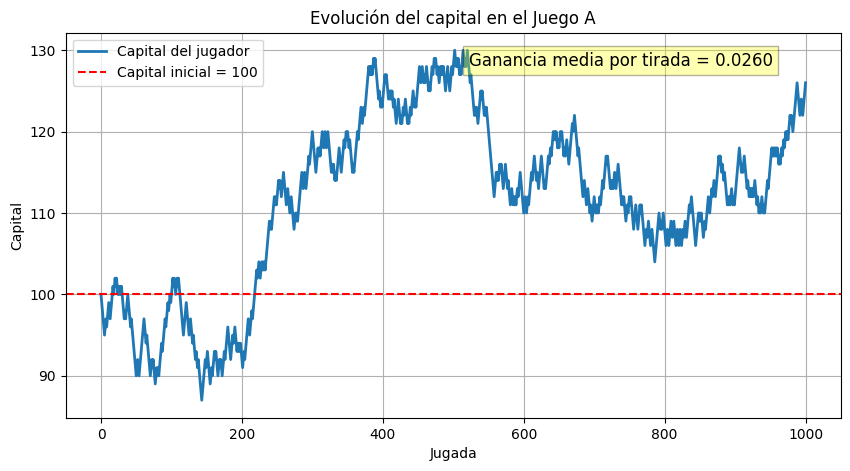

In [4]:
plot_secuencia(juego_A(X_n=100, l_secuencia=1000), multiple=False, juego="A")

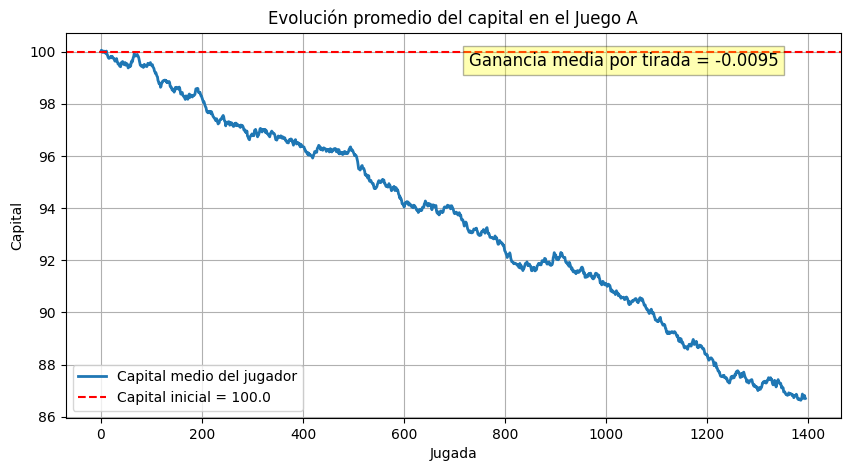

In [5]:
plot_secuencia(juego_A_multiples_promedio(X_n=100, l_secuencia=10000, simulaciones_juegos=300), multiple=True, juego="A")

### Conclusion 

Podemos observar, de manera más representativa cuando usamos varias simulaciones, que el juego A es perdedor, y el valor por simulación de ganancia media por tirada se aproxima cada vez más al valor teórico al incrementar el número de simulaciones.

### Juego B

En este juego comenzamos viendo cuanto dinero tenemos en cada paso y dependiendo del valor dividimos el curso de acción. En esta pequeña condición residirá el truco de la paradoja.

Recordando que $ X_n = Capital del jugador en cada jugada:
- Si $ X_n \bmod 3 = 0 $ → Subestado B1  
  _(se usa la moneda B1)_

- Si $ X_n \bmod 3 \neq 0 $ → Subestado B2  
  _(se usa la moneda B2)_

Entonces dependiendo del capital elegimos una moneda u otras, y estas monedas también están trucadas, y no tan sutilmente como en el juego A

$$
p_{B1} = 0.095 \text{   Probabilidad de victoria de solamente el 9.5\%}
$$ 
$$
p_{B2} = 0.745 \text{   Probabilidad de victoria de casi el 75\%}
$$

Como vemos ya es una diferencia de probabilidad considerable, vamos a observar que sucede si solo jugamos al juego B
De nuevo, cada vez que ganamos nuestro dinero aumenta (+1) y cada vez que perdemos nuestro dinero disminuye (-1).


### Cálculo del valor esperado del Juego B

Sea $X_n \bmod 3 \in \{0,1,2\}$.

Y sean:
$
\pi_0 = \Pr(X_n \equiv 0), \qquad
\pi_1 = \Pr(X_n \equiv 1), \qquad
\pi_2 = \Pr(X_n \equiv 2)
$

Entonces el incremento esperado por jugada es:

$$
\mathbb{E}[\Delta X]
= \pi_0 \, \mathbb{E}[X_0]
+ \pi_1 \, \mathbb{E}[X_1]
+ \pi_2 \, \mathbb{E}[X_2]
$$:

---

#### 1. Estado 1 (capital múltiplo de 3): moneda mala

$
\mathbb{E}[X_0] 
= p(+1) + (1-p)(-1)
$

Como $p_{B1}= 0.095$:

$$
\mathbb{E}[X_0] 
= 2(0.095) - 1 
= -0.81
$$

---

#### 2. Estado 2 y Estado 3 (capital ≡ 1 o 2 mod 3): moneda buena

$$
\mathbb{E}[X_1] 
= \mathbb{E}[X_2]
= p(+1) + (1-p)(-1)
$$

Con $p_{B2} = 0.745$:

$$
\mathbb{E}[X_1] 
= \mathbb{E}[X_2]
= 2(0.745) - 1
= 0.49
$$

---

### Valor esperado total del juego B

Sustituyendo:

$$
\mathbb{E}[\Delta X]
= \pi_0(-0.81)
+ \pi_1(0.49)
+ \pi_2(0.49)
$$

Factorizando:

$$
\boxed{
\mathbb{E}[\Delta X]
= -0.81\, \pi_0
+ 0.49\, (\pi_1 + \pi_2)
}
$$

<img src="imagenes/B2_rewritten.png" width="1600">

Representación del juego B en tres estados en lugar de dos estados con un condicional para poder tratarlo como cadena de Markov

## Averiguar $\pi_0, \pi_1, \pi_2$

El capital del jugador sólo importa módulo 3, así que definimos los estados:

$
0 \equiv X_n \pmod 3,\qquad 
1 \equiv X_n \pmod 3,\qquad
2 \equiv X_n \pmod 3.
$

En el estado $0$ se usa la moneda mala:
$
p_0 = 0.095,\qquad q_0 = 0.905.
$

En los estados $1$ y $2$ se usa la moneda buena:
$
p_1 = p_2 = 0.745,\qquad q_1 = q_2 = 0.255.
$

### Matriz de transición de la cadena módulo 3

Como una ganancia mueve $X$ a $X+1 \pmod 3$ y una pérdida a $X-1 \pmod 3$, la matriz de transición es:

$$
P =
\begin{pmatrix}
0     & p_0  & q_0 \\
q_1   & 0    & p_1 \\
p_2   & q_2  & 0
\end{pmatrix}
=
\begin{pmatrix}
0     & 0.095 & 0.905 \\
0.255 & 0     & 0.745 \\
0.745 & 0.255 & 0
\end{pmatrix}.
$$

### Distribución estacionaria

Queremos $\pi$ tal que:

$
\pi P = \pi,\qquad \pi_0 + \pi_1 + \pi_2 = 1.
$

El sistema queda:

$ 
\begin{cases}
\pi_0 = 0.255\,\pi_1 + 0.745\,\pi_2, \\\\
\pi_1 = 0.095\,\pi_0 + 0.255\,\pi_2, \\\\
\pi_2 = 0.905\,\pi_0 + 0.745\,\pi_1.
\end{cases}
$

In [6]:
# Matriz A y vector b para Aπ = b
A = np.array([
    [1,      -0.255, -0.745],
    [-0.095,  1,     -0.255],
    [-0.905, -0.745,  1     ],
    [1,       1,      1     ]
])
b = np.array([0, 0, 0, 1])

# Resolver usando mínimos cuadrados (sistema sobredeterminado)
pi, *_ = np.linalg.lstsq(A, b, rcond=None)

print(f"Solución (π0 = {pi[0]:.4f}, π1 = {pi[1]:.4f}, π2 = {pi[2]:.4f})")

E_B1 = -0.81    # estado mod 3 = 0
E_B2 = 0.49    # estados mod 3 = 1 o 2

# Valor esperado global del juego B
E_total = pi[0] * E_B1 + (pi[1] + pi[2]) * E_B2

print(f"\nValor esperado de variación del capital = {E_total:.4f}")

Solución (π0 = 0.3836, π1 = 0.1543, π2 = 0.4621)

Valor esperado de variación del capital = -0.0087


### Conclusión
$$
\boxed{
\mathbb{E}[\Delta X]
= -0.81\, \pi_0
+ 0.49\, (\pi_1 + \pi_2)
}
$$

$$
\boxed{\text{El juego B es perdedor en media, a un ratio de perdida de 0.0087 por tirada.}}
$$

# Código Juego B

In [7]:
def juego_B(X_n:int = 100, l_secuencia:int = 1000) -> list[int]: 
    """Simula el juego B de Parrondo.

    Args:
        X_n (int, optional): Cantidad inicial de dinero.
        l_secuencia (int, optional): Número de l_secuencia del juego.

    Returns:
        int: Cantidad final de dinero después de las l_secuencia.
    """
    conteo_estados =[0,0,0]  # Solo para control interno de estados
    X = X_n
    secuencia = [X]
    for _ in range(l_secuencia):
        if X % 3 == 0:
            X += tirar_moneda(0.095)
            conteo_estados[0] += 1
        elif X % 3 == 1:
            X += tirar_moneda(0.745)
            conteo_estados[1] += 1
        elif X % 3 == 2:
            X += tirar_moneda(0.745)
            conteo_estados[2] += 1
        secuencia.append(X)
        if X == 0:
            total_estados = sum(conteo_estados)
            conteo_estados = [x / total_estados for x in conteo_estados]
            return secuencia, conteo_estados
    total_estados = sum(conteo_estados)
    conteo_estados = [x / total_estados for x in conteo_estados]
    return secuencia, conteo_estados

def juego_B_multiples_promedio(X_n:int = 100, l_secuencia:int = 1000, simulaciones_juegos:int = 10) -> list[int]:
    """Simula múltiples veces el juego B y devuelve la secuencia promedio.
    Args:
        X_n (int, optional): Cantidad inicial de dinero.
        l_secuencia (int, optional): Longitud de la secuencia a simular.
        simulaciones_juegos (int, optional): Número de simulaciones a realizar.
    Returns:
        list: Secuencia promedio del capital a lo largo de las simulaciones.
    """
    # Ejecutamos la primera simulación para conocer la longitud base
    primera, conteo_estados = juego_B(X_n, l_secuencia)
    total_conteo_estados = conteo_estados
    L = len(primera)

    # Secuencia de acumulación
    acumulado = [0] * L

    # Sumar todas las simulaciones
    for _ in range(simulaciones_juegos):
        secuencia, conteo_estados = juego_B(X_n, l_secuencia)

        # Si esta secuencia es más corta por ruina, rellenamos
        if len(secuencia) < L:
            secuencia = secuencia + [secuencia[-1]] * (L - len(secuencia))

        # Sumar posición por posición
        for i in range(L):
            acumulado[i] += secuencia[i]
        
        total_conteo_estados = [x + y for x, y in zip(total_conteo_estados, conteo_estados)]

    # Dividir entre el número de simulaciones_juegos para obtener el promedio
    promedio = [x / simulaciones_juegos for x in acumulado]
    total_conteo_estados = [x / simulaciones_juegos for x in total_conteo_estados]
    return promedio, total_conteo_estados

In [8]:
def barplot_lista(valores: list[float]):
    """
    Genera dos bar plots:
    1. Barras individuales B1, B2, B2_
    2. Una única barra con la suma de B2 + B2_
    """
    import matplotlib.pyplot as plt

    # Nombres de las barras del primer plot
    nombres = ["0 mod 3", "1 mod 3", "2 mod 3"]

    # Valor combinado para el segundo plot
    suma_B2 = valores[1] + valores[2]

    fig, axs = plt.subplots(1, 2, figsize=(12, 4))

    # --- Plot 1: barras individuales ---
    axs[0].bar(nombres, valores, color=['blue', 'green', 'purple'])
    axs[0].set_title("Ratio de estados 'individuales'")
    axs[0].set_xlabel("Estado")
    axs[0].set_ylabel("Ratio de uso")
    axs[0].grid(axis='y', linestyle='--', alpha=0.5)

    # --- Plot 2: suma de B2 + B2_ ---
    axs[1].bar(["B1", "B2"], [valores[0], suma_B2], color =['blue', 'orange'])
    axs[1].set_title("Ratio de monedas")
    axs[1].set_xlabel("Estado")
    axs[1].set_ylabel("Ratio total")
    axs[1].grid(axis='y', linestyle='--', alpha=0.5)

    plt.tight_layout()
    plt.show()

# Simulación Juego B

Simulamos el juego B con capital inicial 100 y vamos a ver como evoluciona nuestro capital después de 1000 tiradas, de nuevo solo una simulación no es representativa de la tendendia de todo el juego por lo que también podemos simular varios juegos y agregar los valores de todos los resultados, cuantos más juegos simulemos más se acercará la gráfica al valor teórico de nuestro juego.

### Simulación individual

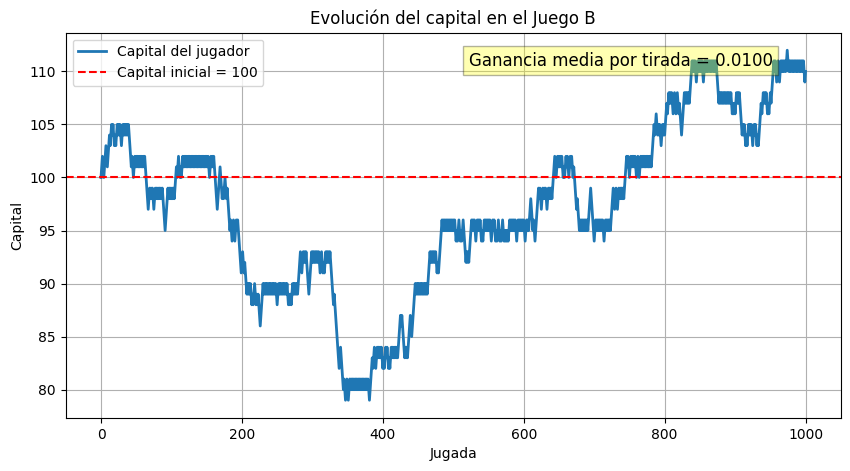

Proporción de uso de monedas en Juego B (B1, B2, B2): [0.377, 0.152, 0.471]


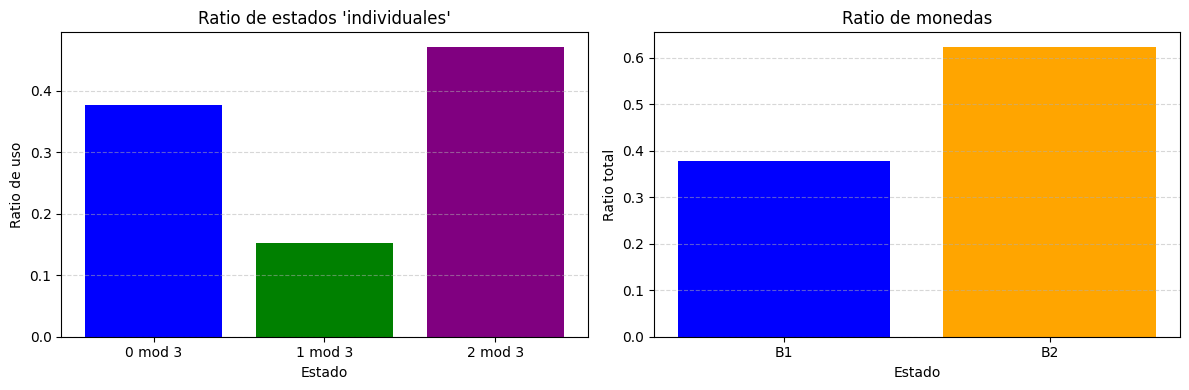

In [9]:
secuencia, conteo_estados = juego_B(X_n=100, l_secuencia=1000)
plot_secuencia(secuencia=secuencia, multiple=False, juego="B")
print("Proporción de uso de monedas en Juego B (B1, B2, B2):", conteo_estados)
barplot_lista(conteo_estados)

### Simulacion multiple

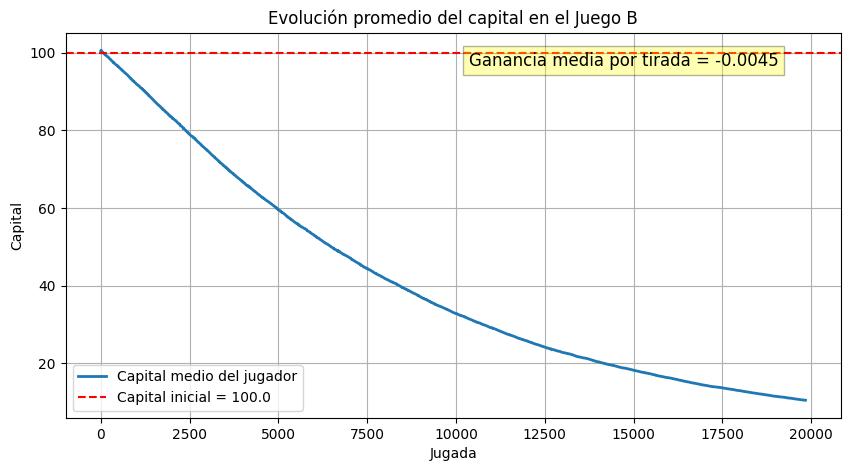

Proporción de uso de monedas en Juego B (B1, B2, B2): [0.3834884818273232, 0.15451842541820815, 0.4620930927544674]


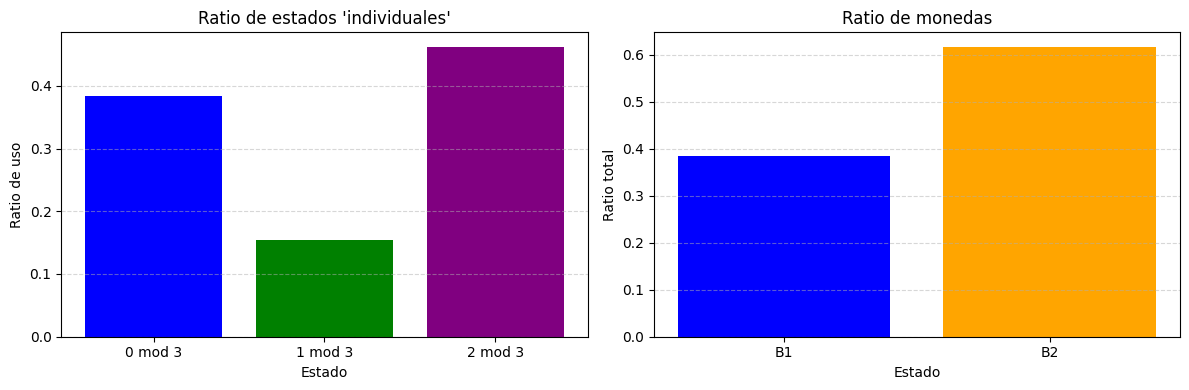

In [10]:
secuencia, conteo_estados = juego_B_multiples_promedio(X_n=100, l_secuencia=100000, simulaciones_juegos=10000)
plot_secuencia(secuencia=secuencia, multiple=True, juego="B")
print("Proporción de uso de monedas en Juego B (B1, B2, B2):", conteo_estados)
barplot_lista(conteo_estados)

### Confirmación del valor esperado con $\pi_0, \pi_1, \pi_2$ obtenidos de manera analítica

In [11]:
E = -0.81 * conteo_estados[0] + 0.49 * (conteo_estados[1] + conteo_estados[2])
E_equitativo = -0.81 * 1/3 + 0.49 * (2/3)
print(f"Valor ratio de pérdida esperado calculado analíticamente: {E:.4f} por tirada.")
print(f"Valor ratio de pérdida esperado en distribución equitativa entre estados: {E_equitativo:.4f} por tirada.")

Valor ratio de pérdida esperado calculado analíticamente: -0.0085 por tirada.
Valor ratio de pérdida esperado en distribución equitativa entre estados: 0.0567 por tirada.


### Conclusión

Como podemos observar, analíticamente también obtenemos el resultado esperado. Cabe resaltar que es importante no solo el valor esperado por estado sino el "tiempo" que se está en cada estado, $\pi_0, \pi_1, \pi_2$. Si los valores hubieran estado repartidos equitativamente entre los tres estados $(\tfrac{1}{3},\, \tfrac{1}{3},\, \tfrac{1}{3})$
hubieramos obtenido un valor esperado por tirada de 0.0567. 

Además, este cálculo muestra que el comportamiento global del sistema no depende únicamente de las recompensas asociadas a cada transición, sino de cómo la cadena distribuye su presencia a la larga. En otras palabras, una misma estructura de pagos puede producir resultados muy distintos si la dinámica del sistema favorece más unos estados que otros. Este contraste entre “valor local” y “frecuencia de visita” es lo que realmente determina el rendimiento final del proceso. Y esto es lo que intentaremos explotar para transformar nuestros juegos perdedores en un juego ganador.

# Conclusiones de juegos separados

Como hemos podido observar, tanto el juego A como el B son juegos perdedores, con:
$$
\mathbb{E}[Juego A]
= -0.01
$$

y

$$
\mathbb{E}[Juego B]
= -0.0087
$$

Entonces, ¿cómo vamos a poder obtener un juego ganador solo considerando estas dos opciones? Parecería algo imposible, pero el truco está en la dependencia del Juego B del capital en el momento. Al ser el juego B más o menos favorable dependiendo del capital (uno de cada 3 para ser exactos), el truco está en evitar los estados perjudiciales y aprovechar los estados ventajosos entrando y saliendo al momento exacto, para ello vamos a usar un ejemplo simplificado de la paradoja de Parrondo mucho más intuitivo para comenzar.

# Paradoja de Parrondo: Ejemplo Simplificado

Queremos mostrar cómo es posible construir un juego ganador combinando dos juegos que, por separado, tienen esperanza negativa. El truco reside en la dependencia del Juego Y respecto a si el capital es par o impar. Aprovecharemos esta estructura para evitar los estados desfavorables y explotar los favorables.

## Juego auxiliar

### Juego X

En cada tirada se obtiene siempre el valor $-1$. Es un juego determinista y claramente perdedor.

### Juego Y

El resultado depende de la paridad del capital:

$Y(X_n) =
\begin{cases}
+3, & \text{si } X_n \text{ es par},
-5, & \text{si } X_n \text{ es impar}.
\end{cases}$

Como el capital alterna entre par e impar, el ciclo de dos pasos produce:

$(+3) + (-5) = -2$

lo que implica un valor esperado por tirada de:

$\mathbb{E}[Y] = -1$

## Combinación XY ganadora

Para obtener un juego ganador debemos usar la dependencia entre estados. La idea es simple:

- Queremos evitar el estado impar del juego Y, pues produce $-5$.
- Para ello alternamos entre los juegos X e Y escogiendo el inicial según la paridad del capital.

Estrategia:

$\text{Si } X_n \text{ es par, jugar primero } Y \text{ y si es impar, jugar primero } X.$

Después, alternamos siempre: $Y, X, Y, X, \dots$

## Ejemplo (capital inicial par)

Sea $X_n = 100$.

$
\begin{aligned}
X_n &= 100 \quad (\text{par}) \\
&\Rightarrow \text{jugar } Y: 100 \mapsto 103 \\
&\text{capital impar} \Rightarrow \text{jugar } X: 103 \mapsto 102 \\
&\text{capital par} \Rightarrow \text{jugar } Y: 102 \mapsto 105 \\
&\text{capital impar} \Rightarrow \text{jugar } X: 105 \mapsto 104 \\
&\text{capital par} \Rightarrow \text{jugar } Y: 104 \mapsto 107
\end{aligned}
$

Se observa que el capital aumenta de manera determinista, evitando siempre la penalización de $-5$ del juego Y.

Si el capital inicial es impar, basta una tirada inicial de X para entrar en la misma dinámica.


<img src="imagenes/Juego_XeY.png" width="1400">

Captura de la explicación del video en Youtube [The Game You Win By Losing (Parrondo's Paradox)](https://www.youtube.com/watch?v=PpvboBJEozM) por Vsauce2

## Conclusión

Dados dos juegos (de una estructura específica) con esperanza negativa existe la posibilidad jugar con la dependencia de estados y obtener una ventaja. Ahora vamos a aplicar esta conclusión a nuestro juego de una manera más sutil y menos determinista.

# Paradoja de Parrondo: Ejemplo inicial

Ahora volvemos con nuestros juegos A y B inciales, los cuales recordamos que de manera independiente tienen valores esperados -0.01 y -0.0087 respectivamente. Para comenzar vamos a ver como diferentes secuencias de cambios entre las secuencias A y B nos dan diferentes valores esperados:

## Código juego AB

In [12]:
def juego_AB(X_n:int = 100, l_secuencia:int = 1000, secuencia_juegos:str = "random") -> list[int]: 
    """Simula el juego combinado AB de Parrondo.

    Args:
        X_n (int, optional): Cantidad inicial de dinero.
        l_secuencia (int, optional): Número de l_secuencia del juego.
        secuencia_juegos (str, optional): Secuencia de juegos a jugar ("random", "AAB", "ABB").

    Returns:
        int: Cantidad final de dinero después de las l_secuencia.
    """
    if secuencia_juegos == "random":
        juegos = ["A", "B"]
        secuencia_juegos = [random.choice(juegos) for _ in range(l_secuencia)]
    else:
        secuencia_juegos = list(secuencia_juegos) * (l_secuencia // len(secuencia_juegos) + 1)
        secuencia_juegos = secuencia_juegos[:l_secuencia]

    conteo_estados =[0,0,0,0]  # Control estados B1, B2, B2_, A
    X = X_n
    secuencia = [X]
    for juego in secuencia_juegos:
        if juego == "A":
            X += tirar_moneda(0.495)
            conteo_estados[3] += 1
        elif juego == "B":
            if X % 3 == 0:
                X += tirar_moneda(0.095)
                conteo_estados[0] += 1
            elif X % 3 == 1:
                X += tirar_moneda(0.745)
                conteo_estados[1] += 1
            elif X % 3 == 2:
                X += tirar_moneda(0.745)
                conteo_estados[2] += 1
        secuencia.append(X)
        if X == 0:
            total_estados = sum(conteo_estados)
            conteo_estados = [x / total_estados for x in conteo_estados]
            return secuencia, conteo_estados
    total_estados = sum(conteo_estados)
    conteo_estados = [x / total_estados for x in conteo_estados]
    return secuencia, conteo_estados

def juego_AB_multiples_promedio(X_n:int = 100, l_secuencia:int = 1000, simulaciones_juegos:int = 100, secuencia_juegos:str = "random") -> list[int]:
    """Simula múltiples veces el juego AB y devuelve la secuencia promedio.
    Args:
        X_n (int, optional): Cantidad inicial de dinero.
        l_secuencia (int, optional): Longitud de la secuencia a simular.
        simulaciones_juegos (int, optional): Número de simulaciones a realizar.
        secuencia_juegos (str, optional): Secuencia de juegos a jugar ("random", "AAB", "ABB").
    Returns:
        list: Secuencia promedio del capital a lo largo de las simulaciones.
    """
    # Ejecutamos la primera simulación para conocer la longitud base
    primera, conteo_estados = juego_AB(X_n, l_secuencia, secuencia_juegos)
    total_conteo_estados = conteo_estados
    L = len(primera)

    # Secuencia de acumulación
    acumulado = [0] * L

    # Sumar todas las simulaciones
    for _ in range(simulaciones_juegos):
        secuencia, conteo_estados = juego_AB(X_n, l_secuencia, secuencia_juegos)

        # Si esta secuencia es más corta por ruina, rellenamos
        if len(secuencia) < L:
            secuencia = secuencia + [secuencia[-1]] * (L - len(secuencia))

        # Sumar posición por posición
        for i in range(L):
            acumulado[i] += secuencia[i]
        
        total_conteo_estados = [x + y for x, y in zip(total_conteo_estados, conteo_estados)]

    # Dividir entre el número de simulaciones_juegos para obtener el promedio
    promedio = [x / simulaciones_juegos for x in acumulado]
    total_conteo_estados = [x / simulaciones_juegos for x in total_conteo_estados]
    return promedio, total_conteo_estados

In [13]:
def barplot_lista_AB(valores: list[float]):
    """
    Genera dos bar plots:
    1. Barras individuales A, B1, B2, B2_
    2. Una única barra con la suma de B2 + B2_
    """
    import matplotlib.pyplot as plt

    # Nombres de las barras del primer plot
    nombres = ["B_0 mod 3", "B_1 mod 3", "B_2 mod 3", "A"]

    # Valor combinado para el segundo plot
    suma_B2 = valores[1] + valores[2]

    fig, axs = plt.subplots(1, 2, figsize=(12, 4))

    # --- Plot 1: barras individuales ---
    axs[0].bar(nombres, valores, color=['blue', 'green', 'purple', 'pink'])
    axs[0].set_title("Ratio de estados 'individuales'")
    axs[0].set_xlabel("Estado")
    axs[0].set_ylabel("Ratio de uso")
    axs[0].grid(axis='y', linestyle='--', alpha=0.5)

    # --- Plot 2: suma de B2 + B2_ ---
    axs[1].bar(["moneda_B1", "moneda_B2", "moneda_A"], [valores[0], suma_B2, valores[3]], color =['blue', 'orange', 'pink'])
    axs[1].set_title("Ratio de monedas")
    axs[1].set_xlabel("Moneda")
    axs[1].set_ylabel("Ratio total")
    axs[1].grid(axis='y', linestyle='--', alpha=0.5)

    plt.tight_layout()
    plt.show()

In [14]:
def plot_juego_AB(secuencia:list[int], ratio_estados:list[float],  multiple:bool = False, secuencia_juegos:str = "random"):
    """Grafica la secuencia del capital a lo largo de las jugadas del juego AB.
    Args:
        X_n (int, optional): Cantidad inicial de dinero.
        l_secuencia (int, optional): Longitud de la secuencia a simular.
        secuencia_juegos (str, optional): Secuencia de juegos a jugar ("random", "AAB", "ABB").
    """
    ganancia_por_tirada = (secuencia[-1] - secuencia[0]) / (len(secuencia) - 1)
    plt.figure(figsize=(10,5))
    
    # Graficar la secuencia del capital
    plt.plot(secuencia, label="Capital medio del jugador" if multiple else "Capital del jugador" , linewidth=2)
    
    # Línea horizontal en el valor inicial
    valor_inicial = secuencia[0]
    plt.axhline(valor_inicial, color='red', linestyle='--', linewidth=1.5,
                label=f"Capital inicial = {valor_inicial}")
    
    plt.text(
    0.52, 0.95, 
    f"Ganancia media por tirada = {ganancia_por_tirada:.4f}",
    transform=plt.gca().transAxes,
    fontsize=12,
    verticalalignment='top',
    bbox=dict(facecolor='yellow', alpha=0.3, edgecolor='black')
    )
    
    plt.xlabel("Jugada")
    plt.ylabel("Capital")
    plt.title(f"Evolución del capital en el Juego AB con secuencia = {secuencia_juegos}" if not multiple else f"Evolución promedio del capital en el Juego AB con secuencia = {secuencia_juegos}")
    plt.legend()
    plt.grid(True)
    plt.show()
    
    barplot_lista_AB(ratio_estados)

## Simulación juego AB

Simulamos la combinación de juegos AB con capital inicial 100 y vamos a ver como evoluciona nuestro capital después de 1000 tiradas, de nuevo solo una simulación no es representativa y cuantos más juegos simulemos y promediemos más se acercará la gráfica al valor teórico de nuestro juego.

### Simulación individual : Random

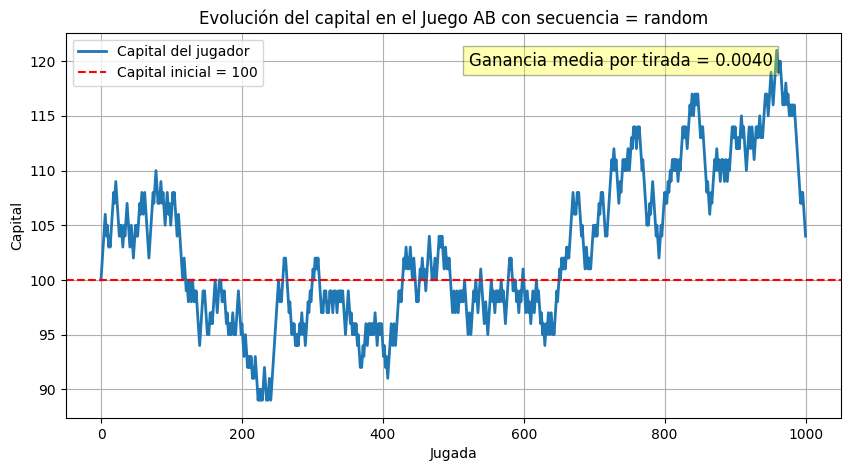

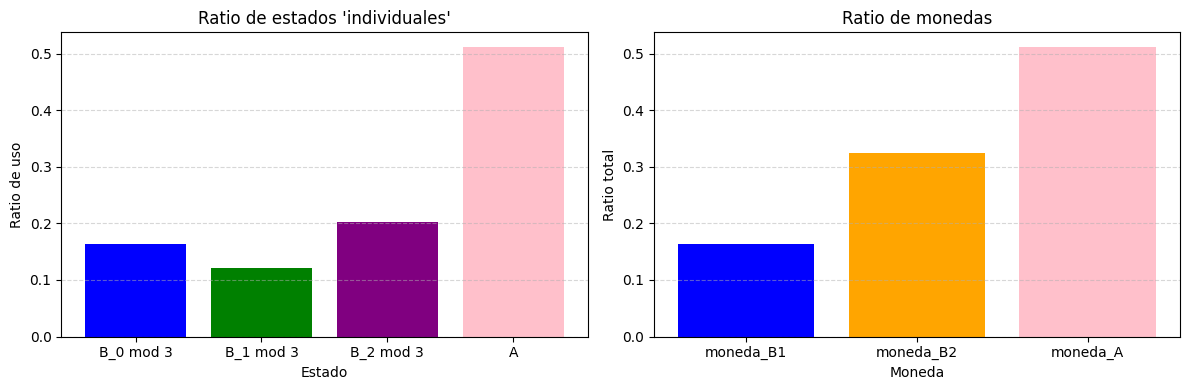

Proporción de uso de monedas en Juego AB (B1, B2, B2_, A): [0.164, 0.122, 0.202, 0.512]


In [15]:
secuencia_juegos = "random"
secuencia, conteo_estados = juego_AB(X_n=100, l_secuencia=1000, secuencia_juegos=secuencia_juegos)
plot_juego_AB(secuencia=secuencia, ratio_estados=conteo_estados, multiple=False, secuencia_juegos=secuencia_juegos)
print("Proporción de uso de monedas en Juego AB (B1, B2, B2_, A):", conteo_estados)

### Simulación multiple : Random

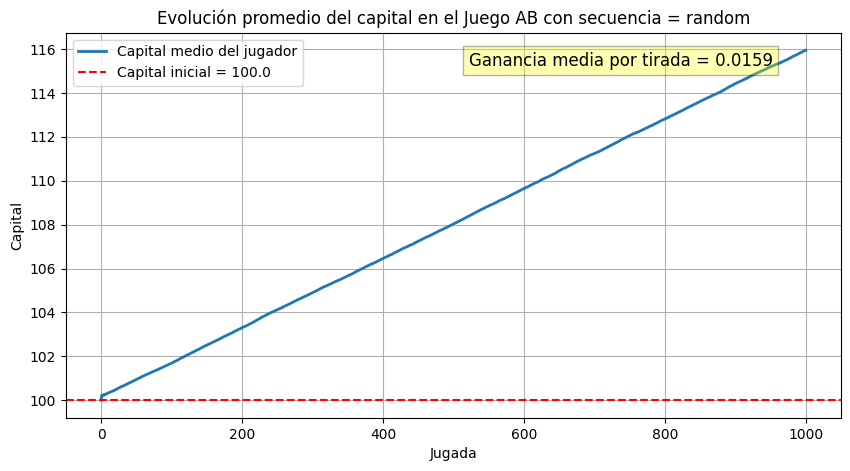

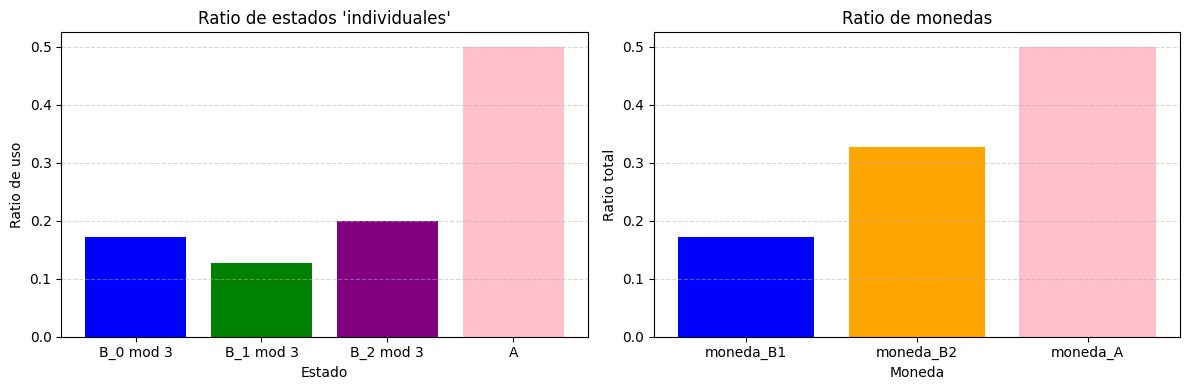

Proporción de uso de monedas en Juego AB (B1, B2, B2_, A): 0.1724, 0.1273, 0.2003, 0.5000


In [16]:
secuencia_juegos = "random"
secuencia, conteo_estados = juego_AB_multiples_promedio(X_n=100, l_secuencia=1000, simulaciones_juegos=100000, secuencia_juegos=secuencia_juegos)
plot_juego_AB(secuencia=secuencia, ratio_estados=conteo_estados, multiple=True, secuencia_juegos=secuencia_juegos)
print(f"Proporción de uso de monedas en Juego AB (B1, B2, B2_, A): {conteo_estados[0]:.4f}, {conteo_estados[1]:.4f}, {conteo_estados[2]:.4f}, {conteo_estados[3]:.4f}")

De igual manera que con los juegos anteriores, el valor esperado del juego es el sumatorio de las probabilidades de estar en el estado n multiplicadas 
por el valor esperado en el estado n, de esta manera vemos que podemos incluir el estado de la moneda A $\pi_3$ añadiéndolo a los estados del juego B. 
$$
\boxed{
\mathbb{E}[\Delta X]
= -0.81\, \pi_0
+ 0.49\, (\pi_1 + \pi_2)
- 0.01\, \pi_3
}
$$

In [17]:
E = -0.81 * conteo_estados[0] + 0.49 * (conteo_estados[1] + conteo_estados[2]) - 0.01 * conteo_estados[3]
E_equitativo = -0.81 * 1/6 + 0.49 * (2/6) - 0.01 * (1/2)
print(f"Valor ratio de pérdida esperado calculado analíticamente con secuencia_juegos = {secuencia_juegos}: {E:.4f} por tirada.")
print(f"Valor ratio de pérdida esperado en distribución equitativa entre estados: {E_equitativo:.4f} por tirada.")

Valor ratio de pérdida esperado calculado analíticamente con secuencia_juegos = random: 0.0159 por tirada.
Valor ratio de pérdida esperado en distribución equitativa entre estados: 0.0233 por tirada.


### Simulación multiple : Cadena no aleatoria

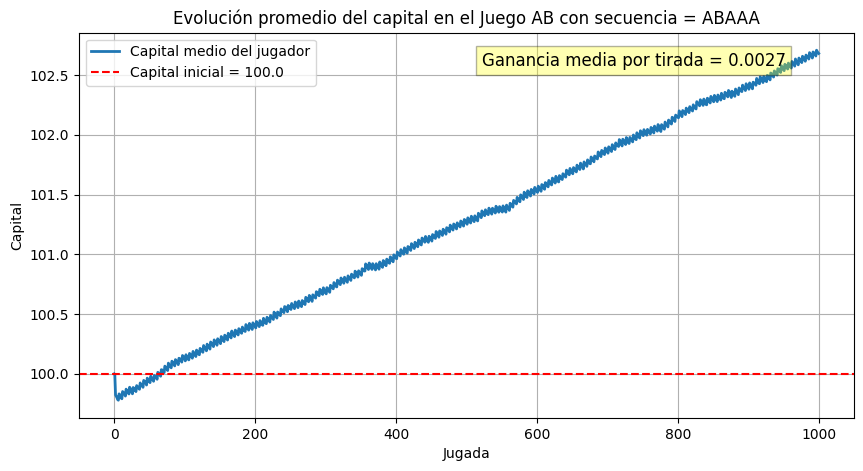

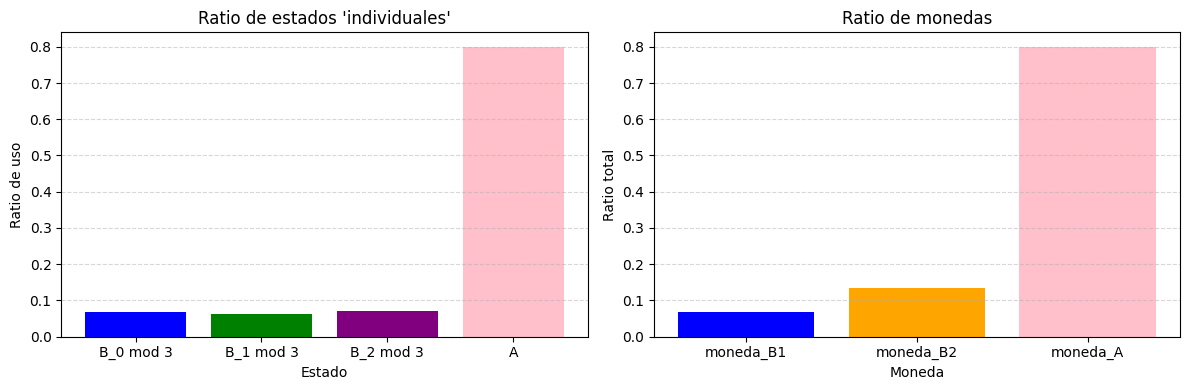

Proporción de uso de monedas en Juego AB (B1, B2, B2_, A): 0.0671, 0.0636, 0.0693, 0.8000


In [18]:
secuencia_juegos = "ABAAA"
secuencia, conteo_estados = juego_AB_multiples_promedio(X_n=100, l_secuencia=1000, simulaciones_juegos=100000, secuencia_juegos=secuencia_juegos)
plot_juego_AB(secuencia=secuencia, ratio_estados=conteo_estados, multiple=True, secuencia_juegos=secuencia_juegos)
print(f"Proporción de uso de monedas en Juego AB (B1, B2, B2_, A): {conteo_estados[0]:.4f}, {conteo_estados[1]:.4f}, {conteo_estados[2]:.4f}, {conteo_estados[3]:.4f}")

$$
\boxed{
\mathbb{E}[\Delta X]
= -0.81\, \pi_0
+ 0.49\, (\pi_1 + \pi_2)
- 0.01\, \pi_3
}
$$

In [19]:
E = -0.81 * conteo_estados[0] + 0.49 * (conteo_estados[1] + conteo_estados[2]) - 0.01 * conteo_estados[3]
E_equitativo = -0.81 * 1/6 + 0.49 * (2/6) - 0.01 * (3/6)
print(f"Valor ratio de pérdida esperado calculado analíticamente con secuencia_juegos = {secuencia_juegos}: {E:.4f} por tirada.")
print(f"Valor ratio de pérdida esperado en distribución equitativa entre estados de B: {E_equitativo:.4f} por tirada.")

Valor ratio de pérdida esperado calculado analíticamente con secuencia_juegos = ABAAA: 0.0028 por tirada.
Valor ratio de pérdida esperado en distribución equitativa entre estados de B: 0.0233 por tirada.


Las gráficas anteriores muestran de forma clara el comportamiento característico de la paradoja de Parrondo. Aunque los juegos A y B son individualmente perdedores, su combinación secuencial genera una dinámica en la que el capital presenta una tendencia positiva. Este resultado refleja que el rendimiento global del sistema no depende únicamente de la esperanza de cada juego por separado, sino de cómo la alternancia entre ellos modifica la probabilidad de visitar estados más favorables.

La intuición de porqué funciona con nuestros juegos A y B reside reconocer tres características principales:

- La desventaja de la moneda A es muy pequeña. 

$$
\mathbb{E}[\Delta X|\text{Juego A}]
= -0.01
$$

- La desventaja de la moneda B no sería visible si el estado $ X_n = 0 \bmod 3$ sucediera con probabilidad cercana a $\frac{1}{3}$, el juego B sería favorable 

$$
\mathbb{E}[\Delta X|\text{Equidistribución de estados de B}]
= -0.81\, \frac{1}{3}
+ 0.49\, (\frac{1}{3} + \frac{1}{3})
= 0.0567
$$

- Al alternar entre el juego A y B, el juego A no penaliza mucho valor esperado, y si que nos "saca" de los búcles más dependientes del juego B, convirtiendo así la proporción de la moneda mala sobre la buena del juego B en algo parecido a $\frac{1}{3}$, $\frac{2}{3}$

$$
\mathbb{E}[\Delta X|\text{Juego A y B con equidistribución de estados de B}]
= -0.81 \cdot \frac{1}{6}
+ 0.4 \cdot \frac{2}{6}
- 0.01 \cdot \frac{3}{6}
= 0.0233
$$

Pero empíricamente no se consigue verdaderamente una proporción $\pi_0 = \frac{1}{3}$, $ \pi_1 + \pi_2 = \frac{2}{3}$.
Obteniendo los valores de la simulación: 

$$
\mathbb{E}[\Delta X|\text{secuencia AB = "random"}]
= -0.81\cdot 0.1723
+ 0.49\, (0.1274 + 0.2003)
- 0.01 \cdot 0.5000
= 0.0160
$$

## Conclusión

De nuevo, incluso partiendo de dos juegos con esperanza negativa, es posible construir una dinámica global que resulte favorable. La clave no está en los juegos por separado, sino en cómo se combinan y en la dependencia del estado en cada momento. Al introducir ratios que condicionan qué juego se juega según el capital, se altera la distribución de tiempo que el sistema pasa en cada estado, y esto puede romper la intuición inicial de que dos juegos perdedores deberían dar un juego perdedor. El resultado final es que la estructura conjunta puede generar una esperanza positiva explotando las relaciones de la manera correcta.

# La ruina del Jugador
Consideramos un jugador que empieza con capital:
$
R_0 = i,\qquad 0 < i < N.
$

En cada apuesta, su capital cambia según:
$
R_{n+1} = R_n + \Delta_n,
$
donde:

- $\Delta_n = +1$ con probabilidad $p$,
- $\Delta_n = -1$ con probabilidad $q = 1-p$,

y cada apuesta es independiente de las anteriores.

Este proceso es un paseo aleatorio simple (*simple random walk*) en los enteros.

---

### 2. Condiciones de paro: barreras absorbentes

El juego termina cuando el capital toca una de las dos barreras:

$
R_\tau \in \{0, N\},
$
donde
$
\tau = \min \{ n \ge 0 : R_n = 0 \text{ o } R_n = N \}.
$

- Si $R_\tau = 0$ → ruina  
- Si $R_\tau = N$ → el jugador gana

---

### 3. Probabilidad de ganar

Definimos:
$
P_i = P(R_\tau = N \mid R_0 = i).
$

Es decir, comenzando con $i$, ¿con qué probabilidad se llega a $N$ antes que a 0?

Sabemos inmediatamente:
$
P_0 = 0, \qquad P_N = 1.
$

---

### 4. Ecuación fundamental: *la ecuación en diferencias*

Condicionamos en el primer paso del proceso.

En la primera apuesta:

- Con prob. $p$, pasamos a $i+1$ y la probabilidad de ganar se convierte en $P_{i+1}$.
- Con prob. $q$, pasamos a $i-1$ y la probabilidad de ganar se convierte en $P_{i-1}$.

Por la propiedad de Markov:
$
P_i = p P_{i+1} + q P_{i-1}, \qquad 1 \le i \le N-1.
$

Esta es la ecuación en diferencias que gobierna el modelo.

Reordenándola:
$
pP_{i+1} - P_i + qP_{i-1} = 0.
$

---

### 5. Resolviendo la ecuación

La ecuación:
$
P_i = pP_{i+1} + qP_{i-1}
$
es lineal y homogénea. Probamos una solución de la forma:
$
P_i = r^i.
$

Sustituyendo:
$
r^i = p r^{i+1} + q r^{i-1}
$
$
1 = p r + q r^{-1}
$
$
p r^2 - r + q = 0.
$

Esta ecuación cuadrática tiene raíces:
$
r_1 = 1,\qquad r_2 = \frac{q}{p}.
$

Por tanto la solución general es:
$
P_i = A + B\left(\frac{q}{p}\right)^i.
$

---

### 6. Imponiendo las condiciones de frontera

Usamos:
$
P_0 = 0,\qquad P_N = 1.
$

- Con $i=0$:
  $
  P_0 = A + B = 0 \quad \Rightarrow \quad A=-B.
  $

- Con $i=N$:
  $
  P_N = A + B\left(\frac{q}{p}\right)^N = 1.
  $

Sustituyendo $A=-B$:
$
-B + B\left(\frac{q}{p}\right)^N = 1
$
$
B\left[\left(\frac{q}{p}\right)^N - 1 \right] = 1
$
$
B = \frac{1}{\left(\frac{q}{p}\right)^N - 1}.
$

Entonces la solución completa es:
$
P_i = \frac{1 - \left(\frac{q}{p}\right)^i}{1 - \left(\frac{q}{p}\right)^N},
\qquad p \ne q.
$

---

### 7. Caso especial: apuesta justa $p = q = \tfrac12$

Cuando $p=q$, las raíces se colapsan y hay que resolver la ecuación de forma diferente.

La ecuación:
$
P_i = \tfrac12 P_{i+1} + \tfrac12 P_{i-1}
$
se convierte en:
$
P_{i+1} - P_i = P_i - P_{i-1},
$
lo que implica incrementos constantes:
$
P_i = Ci + D.
$

Usando:
$
P_0 = 0 \Rightarrow D = 0, \qquad P_N = 1 \Rightarrow C = \frac{1}{N}.
$

Por tanto:
$
P_i = \frac{i}{N}.
$

---

### 8. Probabilidad de ruina

$
\text{Probabilidad de ruina} = 1 - P_i.
$

Es decir:

- Si $p \neq q$:
  $
  1 - P_i = 
  \frac{\left(\frac{q}{p}\right)^i - \left(\frac{q}{p}\right)^N}
       {1 - \left(\frac{q}{p}\right)^N}.
  $

- Si $p=\tfrac12$:
  $
  1 - \frac{i}{N} = \frac{N-i}{N}.
  $


## Código Ruina del Jugador

In [20]:
def ruina_del_jugador(X_n: int = 100, banca:int = 500, numero_simulaciones:int = 1000, p:float = 0.5) -> float:
    """Simula la ruina del jugador con probabilidad p de ganar en cada tirada.

    Args:
        X_n (int, optional): Cantidad inicial de dinero del jugador.
        banca (int, optional): Cantidad inicial de dinero de la banca.
        numero_simulaciones (int, optional): Número de simulaciones a realizar.
        p (float, optional): Probabilidad de ganar en cada tirada.

    Returns:
        float: Proporción de veces que el jugador se arruina.
    """
    ruinas = 0
    secuencias = [0 for _ in range(banca + X_n + 1)]
    for _ in range(numero_simulaciones):
        X = X_n
        B = banca
        secuencia = [X]
        while X > 0 and B > 0:
            resultado = tirar_moneda(p)
            if resultado == 1:
                X += 1
                B -= 1
            else:
                X -= 1
                B += 1
            secuencia.append(X)
        secuencias = [x + y for x, y in zip(secuencias, secuencia + [secuencia[-1]] * (numero_simulaciones - len(secuencia)))]

        if X == 0:
            ruinas += 1

    proporcion_ruina = ruinas / numero_simulaciones
    promedio_secuencia = [x / numero_simulaciones for x in secuencias]
    return proporcion_ruina, promedio_secuencia

def prob_ruina_teorica(i:int, N:int, p:float) -> float:
    """
    Calcula la probabilidad teórica de ruina (1 - P_i)
    para el problema clásico de Gambler's Ruin.

    Args:
        i (int): capital inicial del jugador
        N (int): capital objetivo o barrera superior
        p (float): probabilidad de ganar (+1)

    Returns:
        float: probabilidad de ruina empezando en i
    """
    q = 1 - p

    # Caso p = 1/2 (apuesta justa)
    if abs(p - 0.5) < 1e-12:
        return (N - i) / N

    # Caso p != 1/2 (apuesta sesgada)
    ratio = q / p
    return (ratio**i - ratio**N) / (1 - ratio**N)

def plot_ruina_con_formula(i:int, N:int, numero_simulaciones:int, secuencia_media, ratio_real_ruinas, p):
    """
    Grafica la trayectoria media y añade arriba a la derecha
    la ecuación matemática de la probabilidad teórica de ruina.
    """

    q = 1 - p

    # Construcción de la fórmula en LaTeX
    prob_teorica = prob_ruina_teorica(i, N, p)

    if abs(p - 0.5) < 1e-12:

        formula = (
            r"Probabilidad de ruina:"
            "\n"
            rf"$1 - P_i = \frac{{{N} - {i}}}{{{N}}} = {prob_teorica:.4f}$"
            "\n"
            rf"$\text{{Ruina empírica}} = {ratio_real_ruinas:.4f}$"
        )

    else:

        formula = (
            r"Prob. de ruina: "
            rf"$1 - P_i = \frac{{({q}/{p})^{i} - ({q}/{p})^{N}}}{{1 - ({q}/{p})^{N}}} = {prob_teorica:.4f}$"
            "\n"
            rf"$\text{{Ruina empírica}} = {ratio_real_ruinas:.4f}$"
        )


    # Crear gráfica
    plt.figure(figsize=(10, 5))
    plt.plot(secuencia_media, lw=2, label="Secuencia media")

    plt.title(f"Evolución del capital en {numero_simulaciones} simulaciones: p = {p}, i = {i}, N = {N}")
    plt.xlabel("Número de pasos")
    plt.ylabel("Capital")

    # Recuadro con la fórmula matemática (arriba a la derecha)
    plt.text(
        0.98, 0.95, formula,
        ha='right', va='top',
        transform=plt.gca().transAxes,
        fontsize=12,
        bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black")
    )

    plt.grid(alpha=0.3)
    plt.legend()
    plt.show()

def plot_fila_prob_ruina_vs_p(i: int, lista_N, n_puntos: int = 10):
    """
    Dibuja una fila de subplots, cada uno mostrando la probabilidad teórica de ruina
    en función de p, para distintos valores de N.

    Args:
        i (int): capital inicial del jugador.
        lista_N (list[int]): lista de valores de N (uno por subplot).
        n_puntos (int): número de puntos en el grid de p entre (0,1).
    """
    n_plots = len(lista_N)
    ps = np.linspace(0.15, 0.85, n_puntos)  # evitamos p=0 y p=1

    fig, axes = plt.subplots(1, n_plots, figsize=(4 * n_plots, 4), sharey=True)

    # por si solo hay un N
    if n_plots == 1:
        axes = [axes]

    for ax, N in zip(axes, lista_N):
        probs_ruina = [prob_ruina_teorica(i, N, p) for p in ps]

        ax.plot(ps, probs_ruina)
        ax.set_title(f"N = {N}")
        ax.set_xlabel("p")
        ax.grid(alpha=0.3)

    axes[0].set_ylabel("Prob. teórica de ruina")

    fig.suptitle(f"Probabilidad teórica de ruina vs p (i = {i})", fontsize=14)
    plt.tight_layout(rect=(0, 0, 1, 0.95))
    plt.show()

## Simulaciones Ruina del Jugador

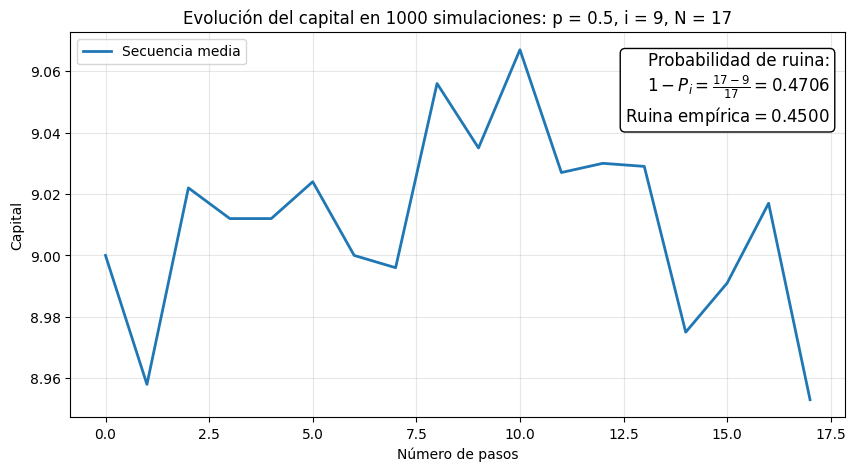

In [21]:
X_n, banca, numero_simulaciones, p = 9, 8, 1000, 0.5
proporcion_ruina, promedio_secuencia  = ruina_del_jugador(X_n, banca,  numero_simulaciones, p)
plot_ruina_con_formula(X_n, X_n + banca, numero_simulaciones, promedio_secuencia, proporcion_ruina, p)

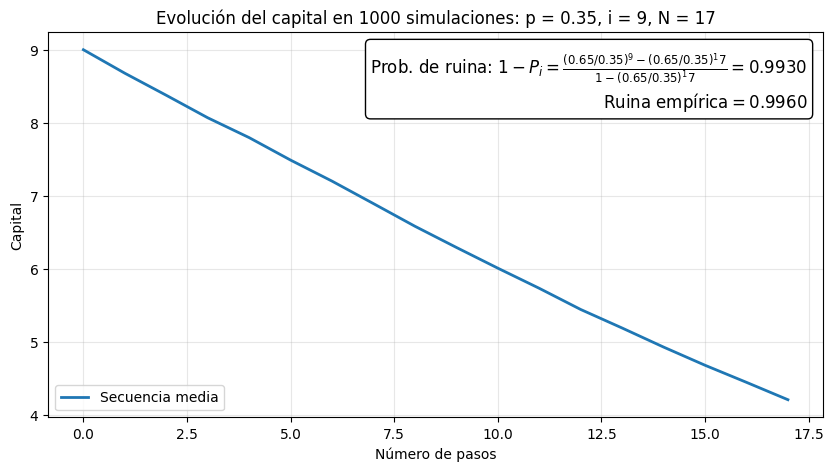

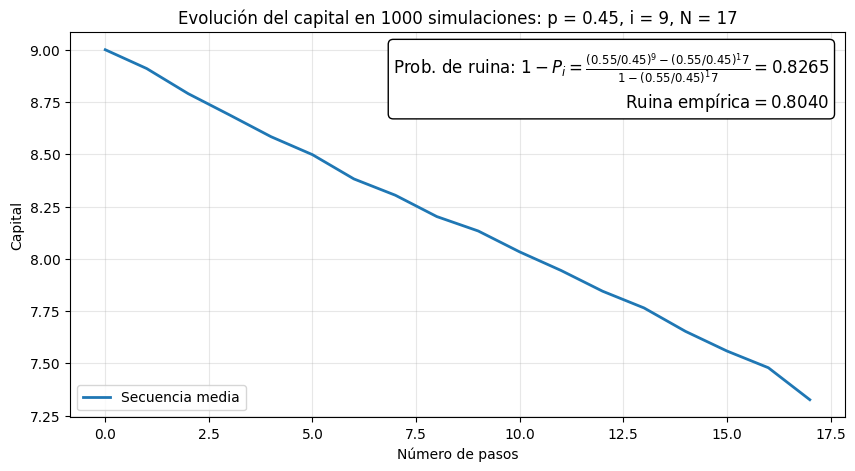

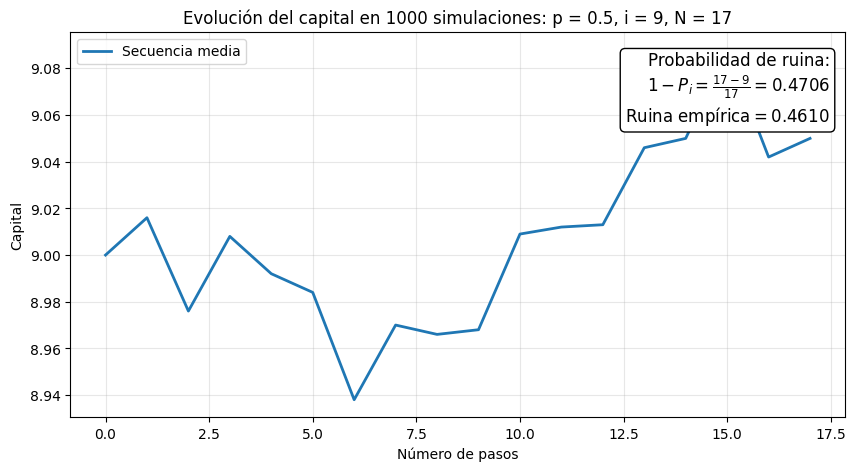

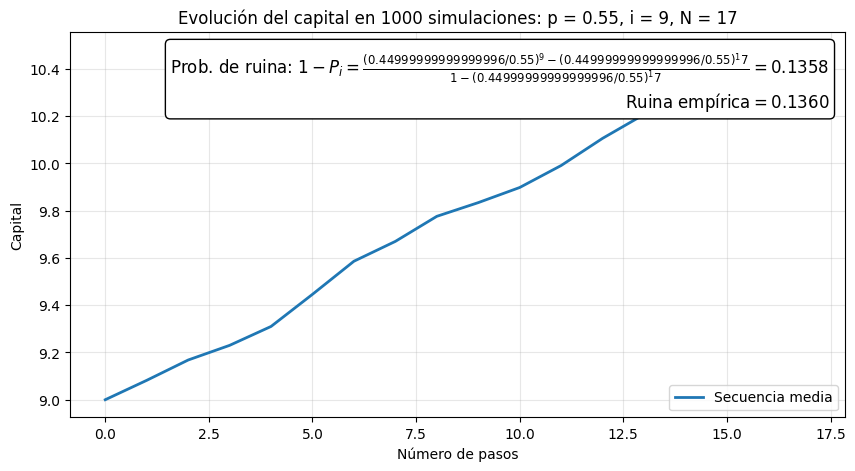

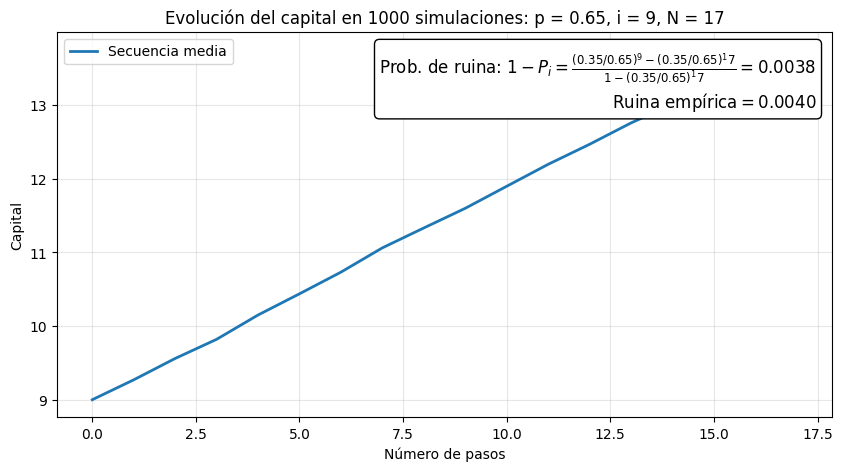

In [22]:
# vamos a plotear para diferentes valores de p
valores_p = [0.35, 0.45, 0.5, 0.55, 0.65]
X_n, banca, numero_simulaciones = 9, 8, 1000
for p in valores_p:
    proporcion_ruina, promedio_secuencia  = ruina_del_jugador(X_n, banca,  numero_simulaciones, p)
    plot_ruina_con_formula(X_n, X_n + banca, numero_simulaciones, promedio_secuencia, proporcion_ruina, p)

### Cambio de la probabilidad de ruina dependiendo de p, para diferentes valores de Banca

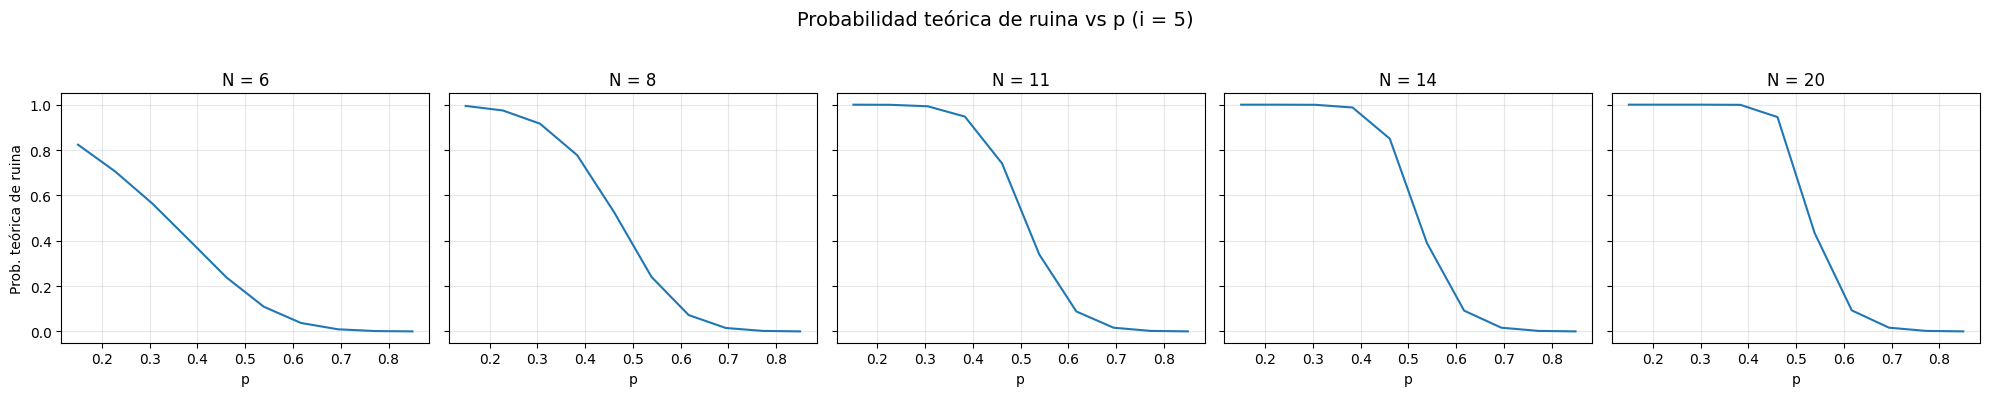

In [23]:
lista_N = [6, 8, 11, 14, 20]  # cada plot un N mayor
i = 5
plot_fila_prob_ruina_vs_p(i, lista_N)

# Conclusiones

## Relación entre la Paradoja de Parrondo y el Problema de la Ruina del Jugador

La paradoja de Parrondo y el modelo de La ruina del Jugador describen fenómenos distintos, pero
están ligados por una idea común: ambos analizan la evolución del capital en un entorno
estocástico con ganancias y pérdidas de una unidad. La conexión aparece al estudiar cómo
las probabilidades de transición, los estados y las barreras afectan al comportamiento a largo
plazo del capital del jugador.

### 1. Paseo aleatorio con barreras

En La ruina del Jugador, el capital sigue un paseo aleatorio homogéneo:
$
R_{n+1} = R_n + \Delta_n,\qquad \Delta_n\in\{+1,-1\},
$
con barreras absorbentes en $0$ (ruina) y $N$ (victoria).

En Parrondo, el capital también evoluciona por incrementos de $\pm 1$, pero las probabilidades
no son constantes, sino que dependen del juego utilizado y del estado del capital módulo 3.

Ambos problemas comparten:
- evolución del capital por saltos unitarios,
- estructura de Markov,
- barreras en el 0 (ruina),
- análisis de probabilidad de supervivencia y esperanza de crecimiento.

### 2. Homogeneidad vs. no homogeneidad

La clave conceptual es:

- En La ruina del Jugador, el proceso es homogéneo:  
  $
  P(\Delta_n = 1) = p \quad \text{para todo } n.
  $

- En Parrondo, el proceso es no homogéneo, porque:
  - el juego cambia en el tiempo (A, B, o patrones AB…),
  - y el juego B tiene probabilidades que dependen de $R_n \bmod 3$.

Esto introduce una estructura de estados internos que modifica la probabilidad de avanzar o retroceder.

### 3. Ruina y ventaja efectiva

El problema de la ruina nos dice que:

- Si $p < 1/2$, el jugador está destinado, con alta probabilidad, a arruinarse.
- Si $p > 1/2$, la probabilidad de ruina decrece, pero nunca desaparece del todo.
- Pequeñas diferencias en $p$ producen cambios drásticos en la probabilidad de ruina.

En Parrondo ocurre algo inesperado:

- Los juegos A y B tienen probabilidades efectivas $p < 1/2$ → cada uno es perdedor.
- Sin embargo, al alternarlos, la probabilidad efectiva de avance se vuelve mayor a 1/2 en el sistema combinado.
- Por tanto, la probabilidad de ruina del sistema combinado disminuye, e incluso puede volverse menor que la de dos juegos perdedores.

En otras palabras, Parrondo altera la probabilidad de transición de tal forma que cambia la tendencia del proceso hacia la ruina o el crecimiento.

### 4. Interpretación conjunta

- La ruina del Jugador explica cómo la probabilidad de ruina depende estrictamente del sesgo $p$.
- La paradoja de Parrondo muestra que no basta con mirar el sesgo de cada juego por separado, sino que importa la dependencia temporal y estructural.
- La combinación de dos paseos aleatorios perdedores puede generar un paseo aleatorio ganador, reduciendo la probabilidad de ruina y aumentando la probabilidad de alcanzar niveles superiores de capital.

En definitiva, Parrondo demuestra que la ruina no depende únicamente de la esperanza de cada apuesta, sino de cómo se estructuran las probabilidades en el tiempo, introduciendo un mecanismo por el cual:
$
p_{\text{efectivo}}> \tfrac12
$
aunque cada juego individual tiene
$
p < \tfrac12.
$

Esto conecta directamente la paradoja de Parrondo con los principios fundamentales del modelo de ruina del jugador.


# Referencias

http://www.columbia.edu/~ks20/FE-Notes/4700-07-Notes-GR.pdf

